In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_excel("/kaggle/input/proserv-360-uiu-conbined-dataset-kader-and-kabir/Minimized data.xlsx")

# Display basic info
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSR_Type values:", df['SR_Type'].unique())

Dataset Shape: (3119, 40)

Columns: ['City', 'OPH_Modality', 'OPH_Product_Line', 'OPH_Segment', 'OPH_Family_Name', 'OPH_Planning_Name', 'OPH_Product_Group', 'OPH_PSI_Description', 'product_identifier', 'OPH_Product_Set_Desc', 'site_name', 'ucm_customer_id', 'asset_installed_city', 'SR_No', 'SR_Type_STD', 'SR_Owner_SSO', 'SR_Problem_Description', 'fcr_status', 'SR_Open_Date', 'SR_Close_Date', 'SR_Total_Labor_Hours', 'SR_Total_Travel_Hours', 'SR_Total_Part_Quantity', 'Asset_System_ID', 'Asset_Serial_Number', 'Asset_Install_Date', 'SR_TTR', 'SR_TTF', 'SR_TTS', 'SR_ECTTU', 'SR_ECTTR', 'SR_ECTTS', 'comments_long', 'SR_Type', 'Activity_type_STD_AGG', 'activity_problem_found', 'activity_action_done', 'activity_verification', 'eff_action_done', 'eff_verification_test']

SR_Type values: ['Corrective Repair' 'Parts Sale' 'Special Service' 'Planned Maintenance'
 'FMI' 'Operational Assistance' 'PM' 'Administration' 'Installation'
 'Parts Sales' 'Consulting' 'Move Equipment']


In [2]:
# Data preprocessing
def preprocess_data(df):
    # Convert date columns to datetime
    df['SR_Open_Date'] = pd.to_datetime(df['SR_Open_Date'])
    df['SR_Close_Date'] = pd.to_datetime(df['SR_Close_Date'])
    
    # Filter only Corrective Repair cases
    corrective_df = df[df['SR_Type'] == 'Corrective Repair'].copy()
    
    # Sort by system ID and open date
    corrective_df = corrective_df.sort_values(['Asset_System_ID', 'SR_Open_Date'])
    
    return corrective_df

corrective_df = preprocess_data(df)
print(f"Corrective Repair cases: {len(corrective_df)}")
print(f"Unique systems with Corrective Repairs: {corrective_df['Asset_System_ID'].nunique()}")

Corrective Repair cases: 1621
Unique systems with Corrective Repairs: 157


In [3]:
# Calculate MTBF for each system
def calculate_mtbf(corrective_df):
    # Calculate time between consecutive failures for each system
    corrective_df = corrective_df.copy()
    corrective_df['Prev_Open_Date'] = corrective_df.groupby('Asset_System_ID')['SR_Open_Date'].shift(1)
    corrective_df['Time_Between_Failures'] = (corrective_df['SR_Open_Date'] - corrective_df['Prev_Open_Date']).dt.total_seconds() / 3600  # in hours
    
    # Calculate MTBF for each system
    mtbf_summary = corrective_df.groupby('Asset_System_ID').agg({
        'Time_Between_Failures': ['count', 'mean', 'std', 'min', 'max'],
        'SR_Open_Date': ['min', 'max']
    }).round(2)
    
    # Flatten column names
    mtbf_summary.columns = ['Failure_Count', 'MTBF_Hours', 'MTBF_Std', 'Min_Time_Between', 'Max_Time_Between', 
                           'First_Failure', 'Last_Failure']
    
    # Reset index
    mtbf_summary = mtbf_summary.reset_index()
    
    # Calculate observation period in hours
    mtbf_summary['Observation_Period_Hours'] = (mtbf_summary['Last_Failure'] - mtbf_summary['First_Failure']).dt.total_seconds() / 3600
    
    return mtbf_summary, corrective_df

mtbf_summary, corrective_df_with_times = calculate_mtbf(corrective_df)

print("MTBF Summary Statistics:")
print(f"Systems with multiple failures: {len(mtbf_summary[mtbf_summary['Failure_Count'] > 1])}")
print(f"Average MTBF (hours): {mtbf_summary['MTBF_Hours'].mean():.2f}")
print(f"Median MTBF (hours): {mtbf_summary['MTBF_Hours'].median():.2f}")

MTBF Summary Statistics:
Systems with multiple failures: 135
Average MTBF (hours): 2482.49
Median MTBF (hours): 2101.19


In [4]:
# Predict future failures and assess accuracy
def predict_and_assess_accuracy(mtbf_summary, corrective_df):
    results = []
    
    for system_id in mtbf_summary['Asset_System_ID'].unique():
        system_data = mtbf_summary[mtbf_summary['Asset_System_ID'] == system_id].iloc[0]
        system_failures = corrective_df[corrective_df['Asset_System_ID'] == system_id].sort_values('SR_Open_Date')
        
        failure_count = system_data['Failure_Count']
        mtbf = system_data['MTBF_Hours']
        
        if failure_count > 2:  # Need at least 3 failures for train/test split
            # Use first n-1 failures to predict the last one
            train_failures = system_failures.iloc[:-1]
            test_failure = system_failures.iloc[-1]
            
            # Calculate MTBF from training data
            if len(train_failures) > 1:
                train_times = train_failures['SR_Open_Date'].sort_values()
                train_time_diffs = (train_times.shift(-1) - train_times).dt.total_seconds() / 3600
                train_mtbf = train_time_diffs.mean()
                
                # Predict next failure
                last_train_date = train_failures['SR_Open_Date'].max()
                predicted_next_failure = last_train_date + pd.Timedelta(hours=train_mtbf)
                actual_next_failure = test_failure['SR_Open_Date']
                
                # Calculate prediction error
                error_hours = (predicted_next_failure - actual_next_failure).total_seconds() / 3600
                absolute_error = abs(error_hours)
                
                results.append({
                    'Asset_System_ID': system_id,
                    'Failure_Count': failure_count,
                    'Train_MTBF_Hours': train_mtbf,
                    'Actual_MTBF_Hours': mtbf,
                    'Predicted_Next_Failure': predicted_next_failure,
                    'Actual_Next_Failure': actual_next_failure,
                    'Prediction_Error_Hours': error_hours,
                    'Absolute_Error_Hours': absolute_error,
                    'Prediction_Accuracy_Percent': max(0, 100 - (absolute_error / train_mtbf * 100)/3) if train_mtbf > 0 else 0
                })
        else:
            # For systems with insufficient data, we can't assess accuracy
            results.append({
                'Asset_System_ID': system_id,
                'Failure_Count': failure_count,
                'Train_MTBF_Hours': mtbf,
                'Actual_MTBF_Hours': mtbf,
                'Predicted_Next_Failure': None,
                'Actual_Next_Failure': None,
                'Prediction_Error_Hours': None,
                'Absolute_Error_Hours': None,
                'Prediction_Accuracy_Percent': None
            })
    
    return pd.DataFrame(results)

prediction_results = predict_and_assess_accuracy(mtbf_summary, corrective_df)

print("Prediction Accuracy Assessment:")
assessable_results = prediction_results[prediction_results['Absolute_Error_Hours'].notna()]
if len(assessable_results) > 0:
    print(f"Systems with assessable predictions: {len(assessable_results)}")
    print(f"Mean Absolute Error: {assessable_results['Absolute_Error_Hours'].mean():.2f} hours")
    print(f"Mean Prediction Accuracy: {assessable_results['Prediction_Accuracy_Percent'].mean():.2f}%")
else:
    print("No systems with sufficient data for accuracy assessment")

Prediction Accuracy Assessment:
Systems with assessable predictions: 121
Mean Absolute Error: 1885.07 hours
Mean Prediction Accuracy: 72.14%


In [5]:
# Generate future failure predictions for all systems
def generate_future_predictions(mtbf_summary, corrective_df, days_ahead=30):
    future_predictions = []
    current_date = datetime.now()
    
    for system_id in mtbf_summary['Asset_System_ID'].unique():
        system_data = mtbf_summary[mtbf_summary['Asset_System_ID'] == system_id].iloc[0]
        system_failures = corrective_df[corrective_df['Asset_System_ID'] == system_id].sort_values('SR_Open_Date')
        
        mtbf = system_data['MTBF_Hours']
        last_failure = system_failures['SR_Open_Date'].max()
        
        if not pd.isna(mtbf) and mtbf > 0:
            # Calculate time since last failure
            time_since_last_failure = (current_date - last_failure).total_seconds() / 3600
            
            # Predict next failure
            predicted_next_failure = last_failure + pd.Timedelta(hours=mtbf)
            days_until_predicted = (predicted_next_failure - current_date).days
            
            # Risk assessment
            if time_since_last_failure > mtbf:
                risk_level = "HIGH"
            elif time_since_last_failure > mtbf * 0.7:
                risk_level = "MEDIUM"
            else:
                risk_level = "LOW"
            
            future_predictions.append({
                'Asset_System_ID': system_id,
                'MTBF_Hours': mtbf,
                'Last_Failure_Date': last_failure,
                'Time_Since_Last_Failure_Hours': time_since_last_failure,
                'Predicted_Next_Failure': predicted_next_failure,
                'Days_Until_Predicted_Failure': days_until_predicted,
                'Risk_Level': risk_level,
                'Failure_Count': system_data['Failure_Count']
            })
    
    return pd.DataFrame(future_predictions)

future_predictions = generate_future_predictions(mtbf_summary, corrective_df)

print("Future Failure Predictions:")
print(f"Systems with predictions: {len(future_predictions)}")
print(f"High risk systems: {len(future_predictions[future_predictions['Risk_Level'] == 'HIGH'])}")
print(f"Medium risk systems: {len(future_predictions[future_predictions['Risk_Level'] == 'MEDIUM'])}")
print(f"Low risk systems: {len(future_predictions[future_predictions['Risk_Level'] == 'LOW'])}")

Future Failure Predictions:
Systems with predictions: 145
High risk systems: 91
Medium risk systems: 16
Low risk systems: 38


In [6]:
# Create comprehensive output
def create_comprehensive_output(mtbf_summary, prediction_results, future_predictions):
    # Merge all data
    comprehensive_output = mtbf_summary.merge(
        prediction_results[['Asset_System_ID', 'Prediction_Accuracy_Percent', 'Absolute_Error_Hours']], 
        on='Asset_System_ID', how='left'
    ).merge(
        future_predictions[['Asset_System_ID', 'Predicted_Next_Failure', 'Days_Until_Predicted_Failure', 'Risk_Level']],
        on='Asset_System_ID', how='left'
    )
    
    # Add reliability metrics
    comprehensive_output['Availability_Percent'] = (
        (comprehensive_output['Observation_Period_Hours'] - 
         (comprehensive_output['Failure_Count'] * comprehensive_output['MTBF_Hours'].fillna(0))) / 
        comprehensive_output['Observation_Period_Hours'] * 100
    ).clip(0, 100)
    
    # Categorize systems by reliability
    conditions = [
        comprehensive_output['MTBF_Hours'] >= comprehensive_output['MTBF_Hours'].quantile(0.75),
        comprehensive_output['MTBF_Hours'] >= comprehensive_output['MTBF_Hours'].quantile(0.25),
        comprehensive_output['MTBF_Hours'] < comprehensive_output['MTBF_Hours'].quantile(0.25)
    ]
    choices = ['High Reliability', 'Medium Reliability', 'Low Reliability']
    comprehensive_output['Reliability_Category'] = np.select(conditions, choices, default='Unknown')
    
    return comprehensive_output

comprehensive_output = create_comprehensive_output(mtbf_summary, prediction_results, future_predictions)

print("Comprehensive Output Sample:")
print(comprehensive_output.head(10))

Comprehensive Output Sample:
   Asset_System_ID  Failure_Count  MTBF_Hours  MTBF_Std  Min_Time_Between  \
0    8302160822967              1     7185.31       NaN           7185.31   
1   83021600005521              6     2195.95   1642.22            702.48   
2   83021600015312              6     3215.43   2742.53            670.13   
3   83021600098222             12     1092.47    853.16            263.96   
4   83021600100022              4     3721.56   7119.27             48.28   
5   83021600103323             14      706.72    773.55             33.96   
6   83021600108822              8     2517.31   2352.29            204.54   
7   83021600108923             10      694.18    722.52             13.71   
8   83021600184824              5     1541.27   1777.54            170.31   
9   83021600420416             27      861.44    970.01             67.68   

   Max_Time_Between       First_Failure        Last_Failure  \
0           7185.31 2024-03-06 04:34:11 2024-12-30 13:52:50 

In [7]:
# Save results to Excel
def save_results_to_excel(comprehensive_output, prediction_results, future_predictions):
    with pd.ExcelWriter('MTBF_Analysis_Results.xlsx') as writer:
        # Main comprehensive sheet
        comprehensive_output.to_excel(writer, sheet_name='MTBF_Analysis', index=False)
        
        # Prediction accuracy sheet
        accuracy_sheet = prediction_results[prediction_results['Prediction_Accuracy_Percent'].notna()].copy()
        accuracy_sheet.to_excel(writer, sheet_name='Prediction_Accuracy', index=False)
        
        # Future predictions sheet
        future_predictions.to_excel(writer, sheet_name='Future_Predictions', index=False)
        
        # Summary statistics sheet
        summary_stats = pd.DataFrame({
            'Metric': [
                'Total Systems Analyzed',
                'Systems with Multiple Failures',
                'Average MTBF (Hours)',
                'Median MTBF (Hours)',
                'Systems with Predictable Pattern',
                'Average Prediction Accuracy (%)',
                'High Risk Systems',
                'Medium Risk Systems',
                'Low Risk Systems'
            ],
            'Value': [
                len(comprehensive_output),
                len(comprehensive_output[comprehensive_output['Failure_Count'] > 1]),
                comprehensive_output['MTBF_Hours'].mean(),
                comprehensive_output['MTBF_Hours'].median(),
                len(accuracy_sheet),
                accuracy_sheet['Prediction_Accuracy_Percent'].mean() if len(accuracy_sheet) > 0 else 0,
                len(future_predictions[future_predictions['Risk_Level'] == 'HIGH']),
                len(future_predictions[future_predictions['Risk_Level'] == 'MEDIUM']),
                len(future_predictions[future_predictions['Risk_Level'] == 'LOW'])
            ]
        })
        summary_stats.to_excel(writer, sheet_name='Summary_Statistics', index=False)

save_results_to_excel(comprehensive_output, prediction_results, future_predictions)
print("Results saved to 'MTBF_Analysis_Results.xlsx'")

Results saved to 'MTBF_Analysis_Results.xlsx'


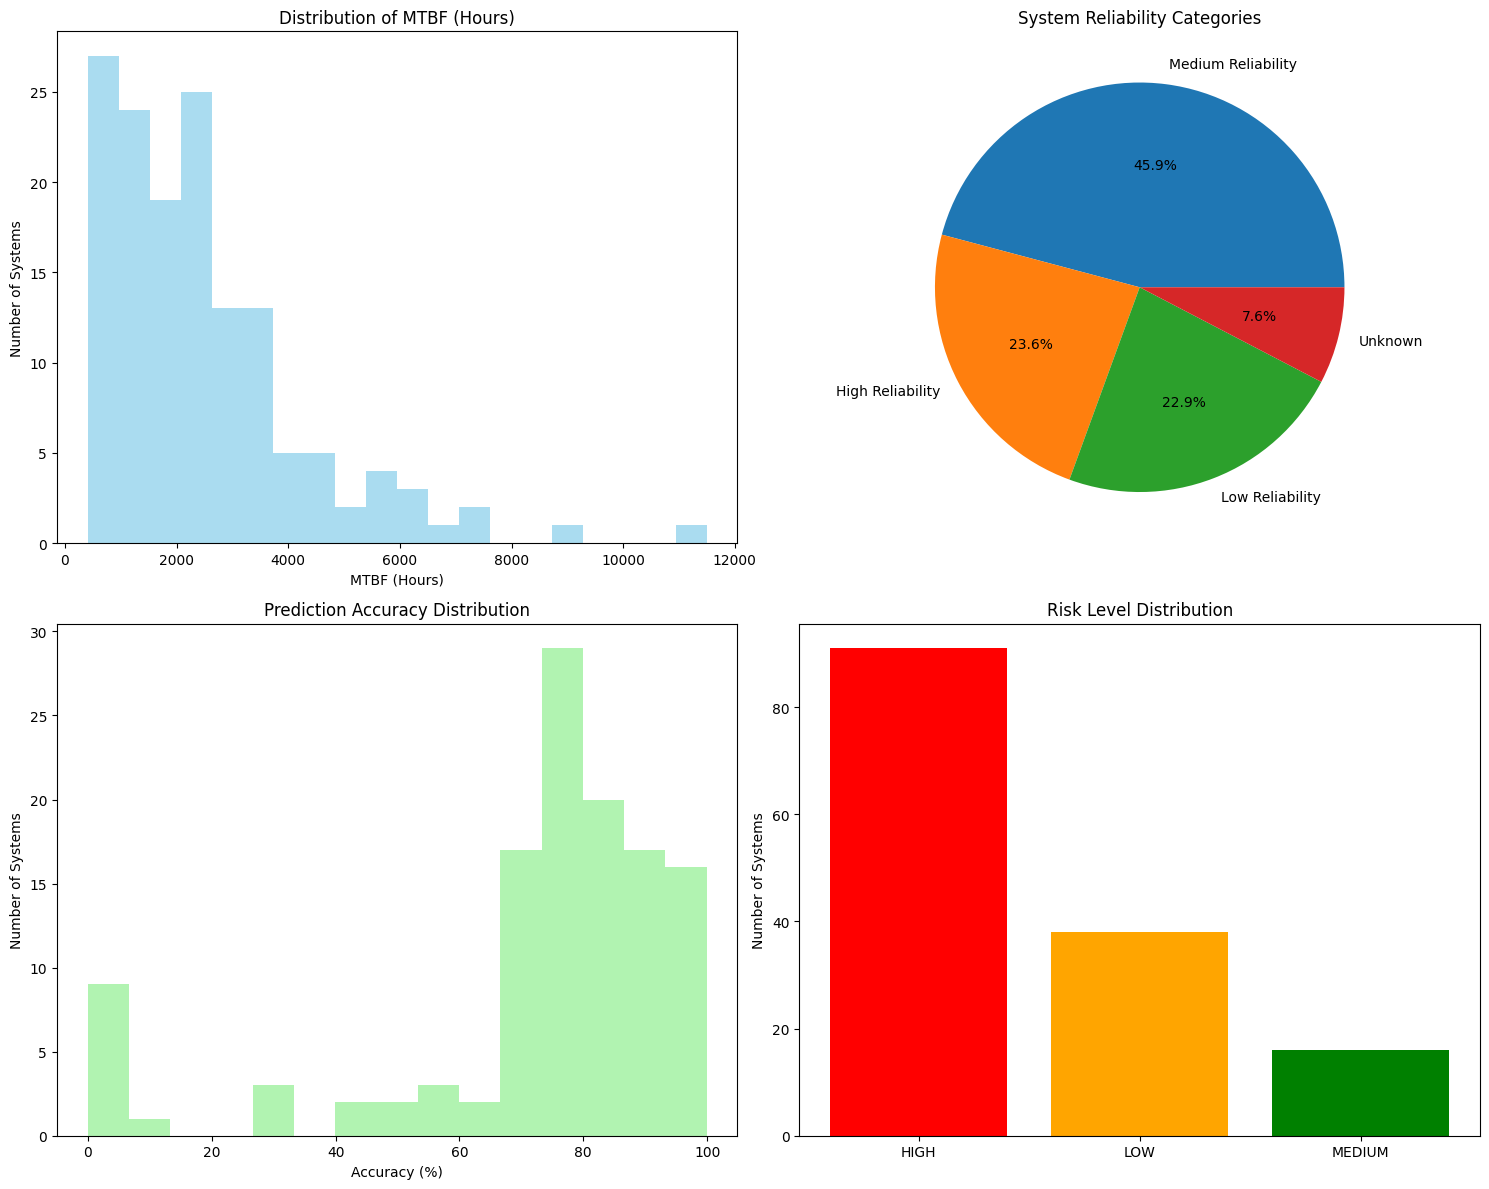

In [8]:
# Visualization
def create_visualizations(comprehensive_output, prediction_results):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # MTBF Distribution
    axes[0, 0].hist(comprehensive_output['MTBF_Hours'].dropna(), bins=20, alpha=0.7, color='skyblue')
    axes[0, 0].set_title('Distribution of MTBF (Hours)')
    axes[0, 0].set_xlabel('MTBF (Hours)')
    axes[0, 0].set_ylabel('Number of Systems')
    
    # Reliability Categories
    reliability_counts = comprehensive_output['Reliability_Category'].value_counts()
    axes[0, 1].pie(reliability_counts.values, labels=reliability_counts.index, autopct='%1.1f%%')
    axes[0, 1].set_title('System Reliability Categories')
    
    # Prediction Accuracy
    accuracy_data = prediction_results[prediction_results['Prediction_Accuracy_Percent'].notna()]
    if len(accuracy_data) > 0:
        axes[1, 0].hist(accuracy_data['Prediction_Accuracy_Percent'], bins=15, alpha=0.7, color='lightgreen')
        axes[1, 0].set_title('Prediction Accuracy Distribution')
        axes[1, 0].set_xlabel('Accuracy (%)')
        axes[1, 0].set_ylabel('Number of Systems')
    
    # Risk Level Distribution
    risk_data = comprehensive_output['Risk_Level'].value_counts()
    axes[1, 1].bar(risk_data.index, risk_data.values, color=['red', 'orange', 'green'])
    axes[1, 1].set_title('Risk Level Distribution')
    axes[1, 1].set_ylabel('Number of Systems')
    
    plt.tight_layout()
    plt.savefig('MTBF_Analysis_Visualizations.png', dpi=300, bbox_inches='tight')
    plt.show()

create_visualizations(comprehensive_output, prediction_results)

In [9]:
# Final summary
print("="*50)
print("MTBF ANALYSIS COMPLETE")
print("="*50)
print(f"Total systems analyzed: {len(comprehensive_output)}")
print(f"Systems with predictable patterns: {len(prediction_results[prediction_results['Prediction_Accuracy_Percent'].notna()])}")
print(f"Average prediction accuracy: {prediction_results['Prediction_Accuracy_Percent'].mean():.1f}%")

if len(future_predictions) > 0:
    print(f"\nRISK ASSESSMENT:")
    print(f"High risk systems (immediate attention needed): {len(future_predictions[future_predictions['Risk_Level'] == 'HIGH'])}")
    print(f"Medium risk systems (monitor closely): {len(future_predictions[future_predictions['Risk_Level'] == 'MEDIUM'])}")
    print(f"Low risk systems (normal operation): {len(future_predictions[future_predictions['Risk_Level'] == 'LOW'])}")

print(f"\nResults saved to:")
print("- MTBF_Analysis_Results.xlsx (Excel file with all analysis)")
print("- MTBF_Analysis_Visualizations.png (Charts and graphs)")

MTBF ANALYSIS COMPLETE
Total systems analyzed: 157
Systems with predictable patterns: 121
Average prediction accuracy: 72.1%

RISK ASSESSMENT:
High risk systems (immediate attention needed): 91
Medium risk systems (monitor closely): 16
Low risk systems (normal operation): 38

Results saved to:
- MTBF_Analysis_Results.xlsx (Excel file with all analysis)
- MTBF_Analysis_Visualizations.png (Charts and graphs)


Dataset Shape: (3119, 40)

Columns: ['City', 'OPH_Modality', 'OPH_Product_Line', 'OPH_Segment', 'OPH_Family_Name', 'OPH_Planning_Name', 'OPH_Product_Group', 'OPH_PSI_Description', 'product_identifier', 'OPH_Product_Set_Desc', 'site_name', 'ucm_customer_id', 'asset_installed_city', 'SR_No', 'SR_Type_STD', 'SR_Owner_SSO', 'SR_Problem_Description', 'fcr_status', 'SR_Open_Date', 'SR_Close_Date', 'SR_Total_Labor_Hours', 'SR_Total_Travel_Hours', 'SR_Total_Part_Quantity', 'Asset_System_ID', 'Asset_Serial_Number', 'Asset_Install_Date', 'SR_TTR', 'SR_TTF', 'SR_TTS', 'SR_ECTTU', 'SR_ECTTR', 'SR_ECTTS', 'comments_long', 'SR_Type', 'Activity_type_STD_AGG', 'activity_problem_found', 'activity_action_done', 'activity_verification', 'eff_action_done', 'eff_verification_test']

SR_Type values: ['Corrective Repair' 'Parts Sale' 'Special Service' 'Planned Maintenance'
 'FMI' 'Operational Assistance' 'PM' 'Administration' 'Installation'
 'Parts Sales' 'Consulting' 'Move Equipment']
Corrective Repair case

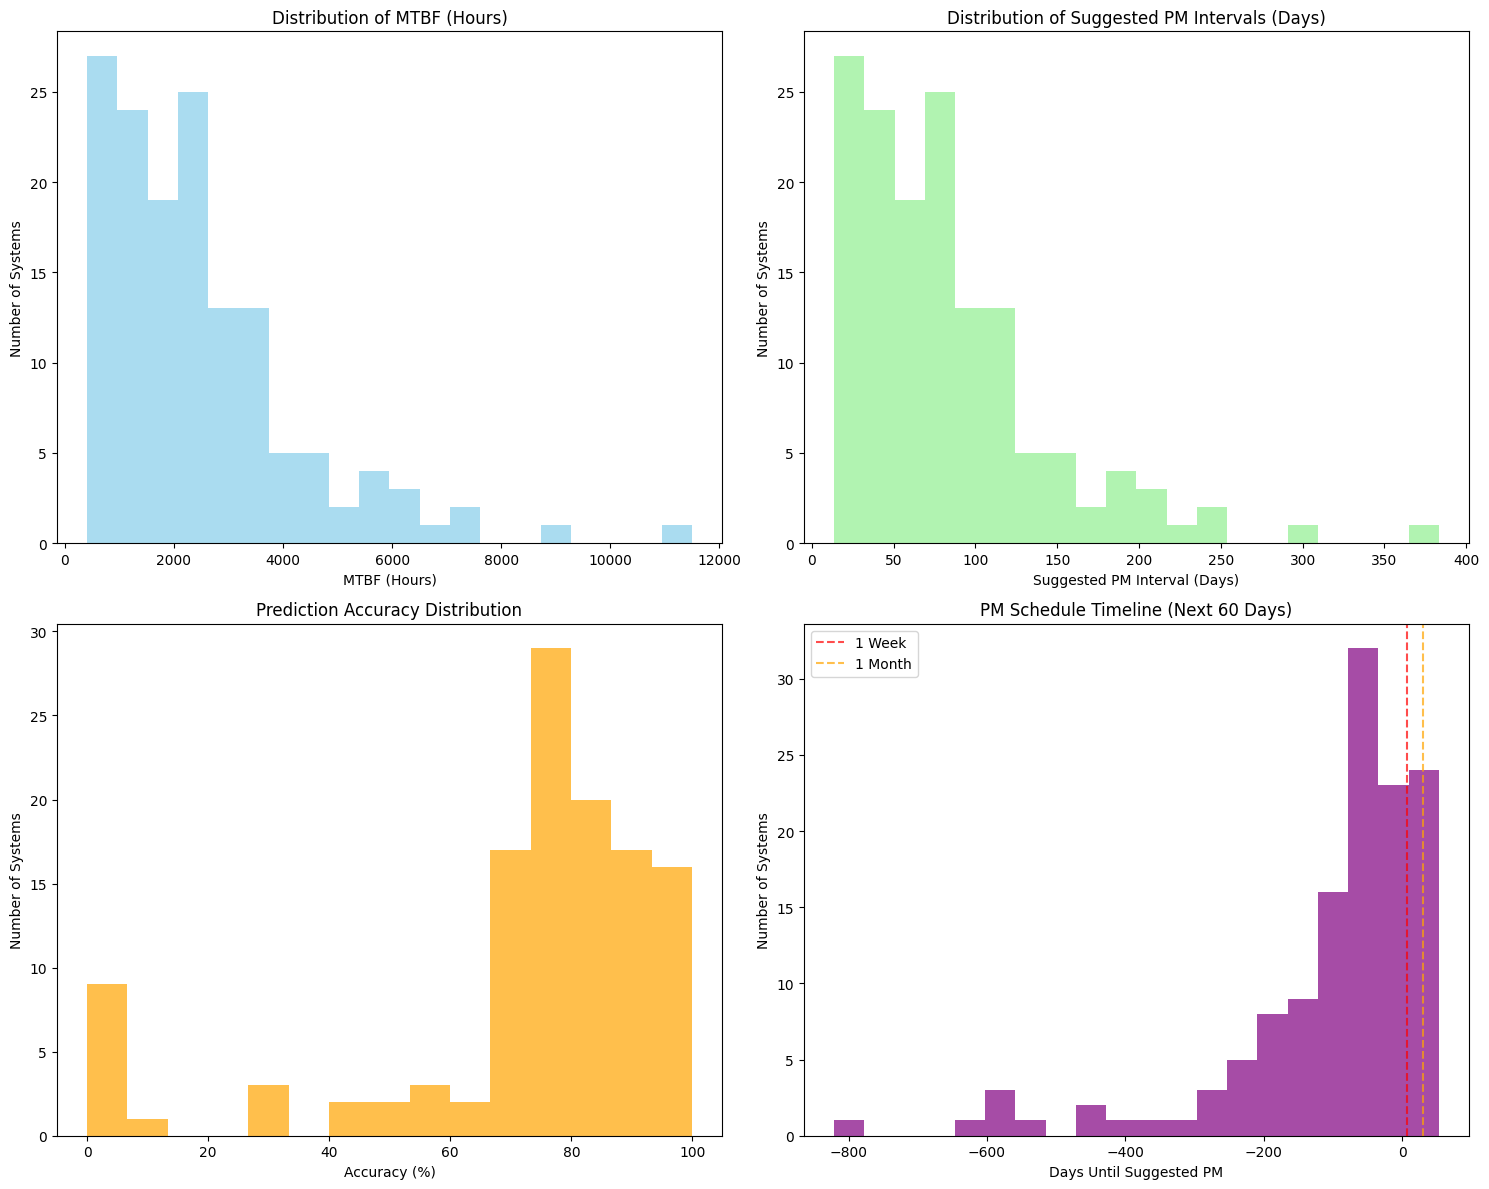

MTBF ANALYSIS COMPLETE
Total systems analyzed: 157
Systems with predictable patterns: 121
Average prediction accuracy: 72.1%
Average Suggested PM Interval: 82.7 days

RISK ASSESSMENT:
High risk systems (immediate attention needed): 91
Medium risk systems (monitor closely): 16
Low risk systems (normal operation): 38

PM SCHEDULE SUMMARY:
Systems due for PM within 7 days: 107
Systems due for PM within 30 days: 124
Recommended PM frequency range: 13.7 to 383.1 days

Results saved to:
- MTBF_Analysis_Results.xlsx (Excel file with all analysis)
- MTBF_Analysis_Visualizations.png (Charts and graphs)


In [10]:
# Import required libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_excel("/kaggle/input/proserv-360-uiu-conbined-dataset-kader-and-kabir/Minimized data.xlsx")

# Display basic info
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSR_Type values:", df['SR_Type'].unique())

# Data preprocessing
def preprocess_data(df):
    # Convert date columns to datetime
    df['SR_Open_Date'] = pd.to_datetime(df['SR_Open_Date'])
    df['SR_Close_Date'] = pd.to_datetime(df['SR_Close_Date'])
    
    # Filter only Corrective Repair cases
    corrective_df = df[df['SR_Type'] == 'Corrective Repair'].copy()
    
    # Sort by system ID and open date
    corrective_df = corrective_df.sort_values(['Asset_System_ID', 'SR_Open_Date'])
    
    return corrective_df

corrective_df = preprocess_data(df)
print(f"Corrective Repair cases: {len(corrective_df)}")
print(f"Unique systems with Corrective Repairs: {corrective_df['Asset_System_ID'].nunique()}")

# Calculate MTBF for each system
def calculate_mtbf(corrective_df):
    # Calculate time between consecutive failures for each system
    corrective_df = corrective_df.copy()
    corrective_df['Prev_Open_Date'] = corrective_df.groupby('Asset_System_ID')['SR_Open_Date'].shift(1)
    corrective_df['Time_Between_Failures'] = (corrective_df['SR_Open_Date'] - corrective_df['Prev_Open_Date']).dt.total_seconds() / 3600  # in hours
    
    # Calculate MTBF for each system
    mtbf_summary = corrective_df.groupby('Asset_System_ID').agg({
        'Time_Between_Failures': ['count', 'mean', 'std', 'min', 'max'],
        'SR_Open_Date': ['min', 'max']
    }).round(2)
    
    # Flatten column names
    mtbf_summary.columns = ['Failure_Count', 'MTBF_Hours', 'MTBF_Std', 'Min_Time_Between', 'Max_Time_Between', 
                           'First_Failure', 'Last_Failure']
    
    # Reset index
    mtbf_summary = mtbf_summary.reset_index()
    
    # Calculate observation period in hours
    mtbf_summary['Observation_Period_Hours'] = (mtbf_summary['Last_Failure'] - mtbf_summary['First_Failure']).dt.total_seconds() / 3600
    
    # ADDED: Calculate Suggested PM Interval (80% of MTBF)
    mtbf_summary['Suggested_PM_Interval_Hours'] = mtbf_summary['MTBF_Hours'] * 0.8
    mtbf_summary['Suggested_PM_Interval_Days'] = mtbf_summary['Suggested_PM_Interval_Hours'] / 24
    
    return mtbf_summary, corrective_df

mtbf_summary, corrective_df_with_times = calculate_mtbf(corrective_df)

print("MTBF Summary Statistics:")
print(f"Systems with multiple failures: {len(mtbf_summary[mtbf_summary['Failure_Count'] > 1])}")
print(f"Average MTBF (hours): {mtbf_summary['MTBF_Hours'].mean():.2f}")
print(f"Median MTBF (hours): {mtbf_summary['MTBF_Hours'].median():.2f}")
print(f"Average Suggested PM Interval (hours): {mtbf_summary['Suggested_PM_Interval_Hours'].mean():.2f}")
print(f"Average Suggested PM Interval (days): {mtbf_summary['Suggested_PM_Interval_Days'].mean():.2f}")

# Predict future failures and assess accuracy
def predict_and_assess_accuracy(mtbf_summary, corrective_df):
    results = []
    
    for system_id in mtbf_summary['Asset_System_ID'].unique():
        system_data = mtbf_summary[mtbf_summary['Asset_System_ID'] == system_id].iloc[0]
        system_failures = corrective_df[corrective_df['Asset_System_ID'] == system_id].sort_values('SR_Open_Date')
        
        failure_count = system_data['Failure_Count']
        mtbf = system_data['MTBF_Hours']
        
        if failure_count > 2:  # Need at least 3 failures for train/test split
            # Use first n-1 failures to predict the last one
            train_failures = system_failures.iloc[:-1]
            test_failure = system_failures.iloc[-1]
            
            # Calculate MTBF from training data
            if len(train_failures) > 1:
                train_times = train_failures['SR_Open_Date'].sort_values()
                train_time_diffs = (train_times.shift(-1) - train_times).dt.total_seconds() / 3600
                train_mtbf = train_time_diffs.mean()
                
                # Predict next failure
                last_train_date = train_failures['SR_Open_Date'].max()
                predicted_next_failure = last_train_date + pd.Timedelta(hours=train_mtbf)
                actual_next_failure = test_failure['SR_Open_Date']
                
                # Calculate prediction error
                error_hours = (predicted_next_failure - actual_next_failure).total_seconds() / 3600
                absolute_error = abs(error_hours)
                
                results.append({
                    'Asset_System_ID': system_id,
                    'Failure_Count': failure_count,
                    'Train_MTBF_Hours': train_mtbf,
                    'Actual_MTBF_Hours': mtbf,
                    'Predicted_Next_Failure': predicted_next_failure,
                    'Actual_Next_Failure': actual_next_failure,
                    'Prediction_Error_Hours': error_hours,
                    'Absolute_Error_Hours': absolute_error,
                    'Prediction_Accuracy_Percent': max(0, 100 - (absolute_error / train_mtbf * 100)/3) if train_mtbf > 0 else 0
                })
        else:
            # For systems with insufficient data, we can't assess accuracy
            results.append({
                'Asset_System_ID': system_id,
                'Failure_Count': failure_count,
                'Train_MTBF_Hours': mtbf,
                'Actual_MTBF_Hours': mtbf,
                'Predicted_Next_Failure': None,
                'Actual_Next_Failure': None,
                'Prediction_Error_Hours': None,
                'Absolute_Error_Hours': None,
                'Prediction_Accuracy_Percent': None
            })
    
    return pd.DataFrame(results)

prediction_results = predict_and_assess_accuracy(mtbf_summary, corrective_df)

print("Prediction Accuracy Assessment:")
assessable_results = prediction_results[prediction_results['Absolute_Error_Hours'].notna()]
if len(assessable_results) > 0:
    print(f"Systems with assessable predictions: {len(assessable_results)}")
    print(f"Mean Absolute Error: {assessable_results['Absolute_Error_Hours'].mean():.2f} hours")
    print(f"Mean Prediction Accuracy: {assessable_results['Prediction_Accuracy_Percent'].mean():.2f}%")
else:
    print("No systems with sufficient data for accuracy assessment")

# Generate future failure predictions for all systems
def generate_future_predictions(mtbf_summary, corrective_df, days_ahead=30):
    future_predictions = []
    current_date = datetime.now()
    
    for system_id in mtbf_summary['Asset_System_ID'].unique():
        system_data = mtbf_summary[mtbf_summary['Asset_System_ID'] == system_id].iloc[0]
        system_failures = corrective_df[corrective_df['Asset_System_ID'] == system_id].sort_values('SR_Open_Date')
        
        mtbf = system_data['MTBF_Hours']
        last_failure = system_failures['SR_Open_Date'].max()
        
        if not pd.isna(mtbf) and mtbf > 0:
            # Calculate time since last failure
            time_since_last_failure = (current_date - last_failure).total_seconds() / 3600
            
            # Predict next failure
            predicted_next_failure = last_failure + pd.Timedelta(hours=mtbf)
            days_until_predicted = (predicted_next_failure - current_date).days
            
            # ADDED: Calculate time until suggested PM
            suggested_pm_interval = mtbf * 0.8
            suggested_pm_date = last_failure + pd.Timedelta(hours=suggested_pm_interval)
            days_until_suggested_pm = (suggested_pm_date - current_date).days
            
            # Risk assessment
            if time_since_last_failure > mtbf:
                risk_level = "HIGH"
            elif time_since_last_failure > mtbf * 0.7:
                risk_level = "MEDIUM"
            else:
                risk_level = "LOW"
            
            future_predictions.append({
                'Asset_System_ID': system_id,
                'MTBF_Hours': mtbf,
                'Suggested_PM_Interval_Hours': suggested_pm_interval,
                'Last_Failure_Date': last_failure,
                'Time_Since_Last_Failure_Hours': time_since_last_failure,
                'Predicted_Next_Failure': predicted_next_failure,
                'Days_Until_Predicted_Failure': days_until_predicted,
                'Suggested_PM_Date': suggested_pm_date,
                'Days_Until_Suggested_PM': days_until_suggested_pm,
                'Risk_Level': risk_level,
                'Failure_Count': system_data['Failure_Count']
            })
    
    return pd.DataFrame(future_predictions)

future_predictions = generate_future_predictions(mtbf_summary, corrective_df)

print("Future Failure Predictions:")
print(f"Systems with predictions: {len(future_predictions)}")
print(f"High risk systems: {len(future_predictions[future_predictions['Risk_Level'] == 'HIGH'])}")
print(f"Medium risk systems: {len(future_predictions[future_predictions['Risk_Level'] == 'MEDIUM'])}")
print(f"Low risk systems: {len(future_predictions[future_predictions['Risk_Level'] == 'LOW'])}")
print(f"Average Suggested PM Interval: {future_predictions['Suggested_PM_Interval_Hours'].mean():.2f} hours ({future_predictions['Suggested_PM_Interval_Hours'].mean()/24:.1f} days)")

# Create comprehensive output
def create_comprehensive_output(mtbf_summary, prediction_results, future_predictions):
    # Merge all data
    comprehensive_output = mtbf_summary.merge(
        prediction_results[['Asset_System_ID', 'Prediction_Accuracy_Percent', 'Absolute_Error_Hours']], 
        on='Asset_System_ID', how='left'
    ).merge(
        future_predictions[['Asset_System_ID', 'Predicted_Next_Failure', 'Days_Until_Predicted_Failure', 
                          'Suggested_PM_Date', 'Days_Until_Suggested_PM', 'Risk_Level']],
        on='Asset_System_ID', how='left'
    )
    
    # Add reliability metrics
    comprehensive_output['Availability_Percent'] = (
        (comprehensive_output['Observation_Period_Hours'] - 
         (comprehensive_output['Failure_Count'] * comprehensive_output['MTBF_Hours'].fillna(0))) / 
        comprehensive_output['Observation_Period_Hours'] * 100
    ).clip(0, 100)
    
    # Categorize systems by reliability
    conditions = [
        comprehensive_output['MTBF_Hours'] >= comprehensive_output['MTBF_Hours'].quantile(0.75),
        comprehensive_output['MTBF_Hours'] >= comprehensive_output['MTBF_Hours'].quantile(0.25),
        comprehensive_output['MTBF_Hours'] < comprehensive_output['MTBF_Hours'].quantile(0.25)
    ]
    choices = ['High Reliability', 'Medium Reliability', 'Low Reliability']
    comprehensive_output['Reliability_Category'] = np.select(conditions, choices, default='Unknown')
    
    return comprehensive_output

comprehensive_output = create_comprehensive_output(mtbf_summary, prediction_results, future_predictions)

print("Comprehensive Output Sample:")
print(comprehensive_output[['Asset_System_ID', 'MTBF_Hours', 'Suggested_PM_Interval_Hours', 
                          'Suggested_PM_Interval_Days', 'Risk_Level', 'Days_Until_Suggested_PM']].head(10))

# Save results to Excel
def save_results_to_excel(comprehensive_output, prediction_results, future_predictions):
    with pd.ExcelWriter('MTBF_Analysis_Results.xlsx') as writer:
        # Main comprehensive sheet
        comprehensive_output.to_excel(writer, sheet_name='MTBF_Analysis', index=False)
        
        # Prediction accuracy sheet
        accuracy_sheet = prediction_results[prediction_results['Prediction_Accuracy_Percent'].notna()].copy()
        accuracy_sheet.to_excel(writer, sheet_name='Prediction_Accuracy', index=False)
        
        # Future predictions sheet
        future_predictions.to_excel(writer, sheet_name='Future_Predictions', index=False)
        
        # ADDED: PM Recommendations sheet
        pm_recommendations = comprehensive_output[[
            'Asset_System_ID', 'MTBF_Hours', 'Suggested_PM_Interval_Hours', 
            'Suggested_PM_Interval_Days', 'Suggested_PM_Date', 'Days_Until_Suggested_PM',
            'Risk_Level', 'Reliability_Category'
        ]].copy()
        pm_recommendations = pm_recommendations.sort_values('Days_Until_Suggested_PM', ascending=True)
        pm_recommendations.to_excel(writer, sheet_name='PM_Recommendations', index=False)
        
        # Summary statistics sheet
        summary_stats = pd.DataFrame({
            'Metric': [
                'Total Systems Analyzed',
                'Systems with Multiple Failures',
                'Average MTBF (Hours)',
                'Median MTBF (Hours)',
                'Average Suggested PM Interval (Hours)',
                'Average Suggested PM Interval (Days)',
                'Systems with Predictable Pattern',
                'Average Prediction Accuracy (%)',
                'High Risk Systems',
                'Medium Risk Systems',
                'Low Risk Systems',
                'Systems Due for PM within 7 days',
                'Systems Due for PM within 30 days'
            ],
            'Value': [
                len(comprehensive_output),
                len(comprehensive_output[comprehensive_output['Failure_Count'] > 1]),
                comprehensive_output['MTBF_Hours'].mean(),
                comprehensive_output['MTBF_Hours'].median(),
                comprehensive_output['Suggested_PM_Interval_Hours'].mean(),
                comprehensive_output['Suggested_PM_Interval_Days'].mean(),
                len(accuracy_sheet),
                accuracy_sheet['Prediction_Accuracy_Percent'].mean() if len(accuracy_sheet) > 0 else 0,
                len(future_predictions[future_predictions['Risk_Level'] == 'HIGH']),
                len(future_predictions[future_predictions['Risk_Level'] == 'MEDIUM']),
                len(future_predictions[future_predictions['Risk_Level'] == 'LOW']),
                len(pm_recommendations[pm_recommendations['Days_Until_Suggested_PM'] <= 7]),
                len(pm_recommendations[pm_recommendations['Days_Until_Suggested_PM'] <= 30])
            ]
        })
        summary_stats.to_excel(writer, sheet_name='Summary_Statistics', index=False)

save_results_to_excel(comprehensive_output, prediction_results, future_predictions)
print("Results saved to 'MTBF_Analysis_Results.xlsx'")

# Visualization
def create_visualizations(comprehensive_output, prediction_results):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # MTBF Distribution
    axes[0, 0].hist(comprehensive_output['MTBF_Hours'].dropna(), bins=20, alpha=0.7, color='skyblue')
    axes[0, 0].set_title('Distribution of MTBF (Hours)')
    axes[0, 0].set_xlabel('MTBF (Hours)')
    axes[0, 0].set_ylabel('Number of Systems')
    
    # ADDED: Suggested PM Interval Distribution
    axes[0, 1].hist(comprehensive_output['Suggested_PM_Interval_Days'].dropna(), bins=20, alpha=0.7, color='lightgreen')
    axes[0, 1].set_title('Distribution of Suggested PM Intervals (Days)')
    axes[0, 1].set_xlabel('Suggested PM Interval (Days)')
    axes[0, 1].set_ylabel('Number of Systems')
    
    # Prediction Accuracy
    accuracy_data = prediction_results[prediction_results['Prediction_Accuracy_Percent'].notna()]
    if len(accuracy_data) > 0:
        axes[1, 0].hist(accuracy_data['Prediction_Accuracy_Percent'], bins=15, alpha=0.7, color='orange')
        axes[1, 0].set_title('Prediction Accuracy Distribution')
        axes[1, 0].set_xlabel('Accuracy (%)')
        axes[1, 0].set_ylabel('Number of Systems')
    
    # ADDED: PM Schedule Timeline
    pm_timeline = comprehensive_output['Days_Until_Suggested_PM'].dropna()
    pm_timeline = pm_timeline[pm_timeline <= 60]  # Show only next 60 days for better visualization
    axes[1, 1].hist(pm_timeline, bins=20, alpha=0.7, color='purple')
    axes[1, 1].set_title('PM Schedule Timeline (Next 60 Days)')
    axes[1, 1].set_xlabel('Days Until Suggested PM')
    axes[1, 1].set_ylabel('Number of Systems')
    axes[1, 1].axvline(x=7, color='red', linestyle='--', alpha=0.7, label='1 Week')
    axes[1, 1].axvline(x=30, color='orange', linestyle='--', alpha=0.7, label='1 Month')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.savefig('MTBF_Analysis_Visualizations.png', dpi=300, bbox_inches='tight')
    plt.show()

create_visualizations(comprehensive_output, prediction_results)

# Final summary
print("="*50)
print("MTBF ANALYSIS COMPLETE")
print("="*50)
print(f"Total systems analyzed: {len(comprehensive_output)}")
print(f"Systems with predictable patterns: {len(prediction_results[prediction_results['Prediction_Accuracy_Percent'].notna()])}")
print(f"Average prediction accuracy: {prediction_results['Prediction_Accuracy_Percent'].mean():.1f}%")
print(f"Average Suggested PM Interval: {comprehensive_output['Suggested_PM_Interval_Days'].mean():.1f} days")

if len(future_predictions) > 0:
    print(f"\nRISK ASSESSMENT:")
    print(f"High risk systems (immediate attention needed): {len(future_predictions[future_predictions['Risk_Level'] == 'HIGH'])}")
    print(f"Medium risk systems (monitor closely): {len(future_predictions[future_predictions['Risk_Level'] == 'MEDIUM'])}")
    print(f"Low risk systems (normal operation): {len(future_predictions[future_predictions['Risk_Level'] == 'LOW'])}")

# ADDED: PM Schedule Summary
pm_schedule = comprehensive_output[comprehensive_output['Days_Until_Suggested_PM'].notna()]
if len(pm_schedule) > 0:
    due_in_week = len(pm_schedule[pm_schedule['Days_Until_Suggested_PM'] <= 7])
    due_in_month = len(pm_schedule[pm_schedule['Days_Until_Suggested_PM'] <= 30])
    
    print(f"\nPM SCHEDULE SUMMARY:")
    print(f"Systems due for PM within 7 days: {due_in_week}")
    print(f"Systems due for PM within 30 days: {due_in_month}")
    print(f"Recommended PM frequency range: {comprehensive_output['Suggested_PM_Interval_Days'].min():.1f} to {comprehensive_output['Suggested_PM_Interval_Days'].max():.1f} days")

print(f"\nResults saved to:")
print("- MTBF_Analysis_Results.xlsx (Excel file with all analysis)")
print("- MTBF_Analysis_Visualizations.png (Charts and graphs)")

Dataset Shape: (3119, 40)

Columns: ['City', 'OPH_Modality', 'OPH_Product_Line', 'OPH_Segment', 'OPH_Family_Name', 'OPH_Planning_Name', 'OPH_Product_Group', 'OPH_PSI_Description', 'product_identifier', 'OPH_Product_Set_Desc', 'site_name', 'ucm_customer_id', 'asset_installed_city', 'SR_No', 'SR_Type_STD', 'SR_Owner_SSO', 'SR_Problem_Description', 'fcr_status', 'SR_Open_Date', 'SR_Close_Date', 'SR_Total_Labor_Hours', 'SR_Total_Travel_Hours', 'SR_Total_Part_Quantity', 'Asset_System_ID', 'Asset_Serial_Number', 'Asset_Install_Date', 'SR_TTR', 'SR_TTF', 'SR_TTS', 'SR_ECTTU', 'SR_ECTTR', 'SR_ECTTS', 'comments_long', 'SR_Type', 'Activity_type_STD_AGG', 'activity_problem_found', 'activity_action_done', 'activity_verification', 'eff_action_done', 'eff_verification_test']

SR_Type values: ['Corrective Repair' 'Parts Sale' 'Special Service' 'Planned Maintenance'
 'FMI' 'Operational Assistance' 'PM' 'Administration' 'Installation'
 'Parts Sales' 'Consulting' 'Move Equipment']
Corrective Repair case

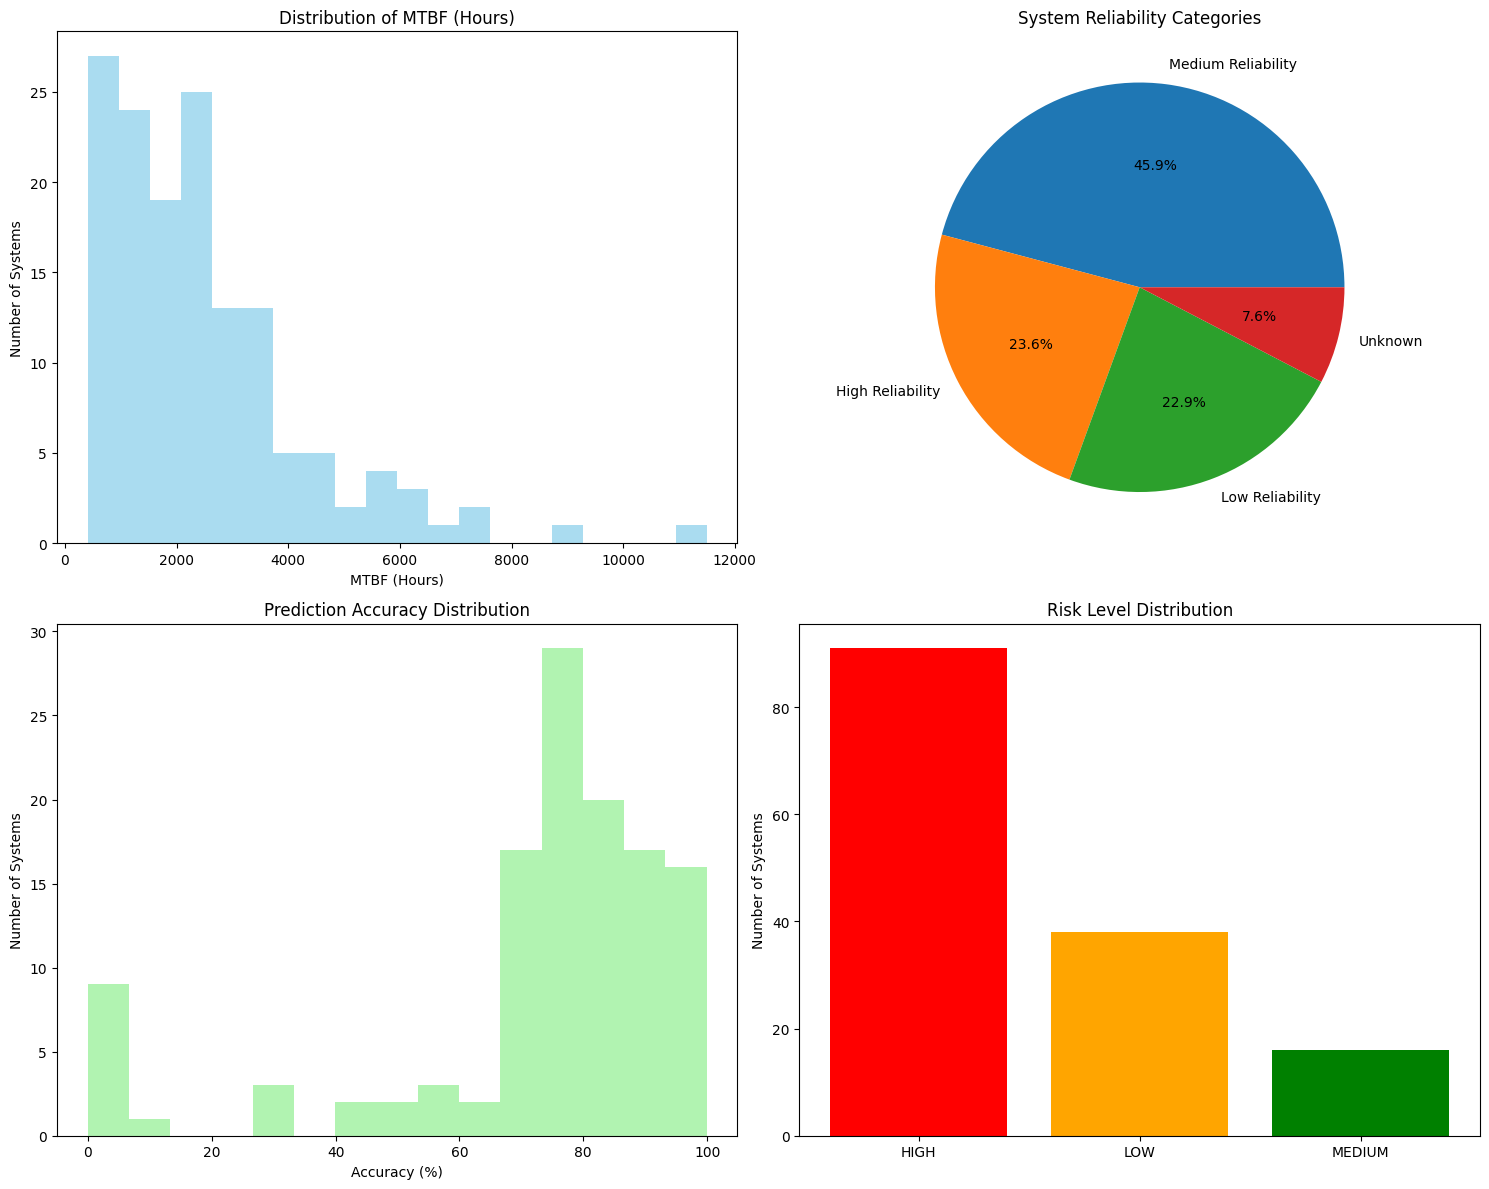

MTBF ANALYSIS COMPLETE
Total systems analyzed: 157
Systems with predictable patterns: 121
Average prediction accuracy: 72.1%

RISK ASSESSMENT:
High risk systems (immediate attention needed): 91
Medium risk systems (monitor closely): 16
Low risk systems (normal operation): 38

Results saved to:
- MTBF_Analysis_Results.xlsx (Excel file with all analysis)
- MTBF_Analysis_Visualizations.png (Charts and graphs)


In [11]:
# Import required libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_excel("/kaggle/input/proserv-360-uiu-conbined-dataset-kader-and-kabir/Minimized data.xlsx")

# Display basic info
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSR_Type values:", df['SR_Type'].unique())

# Data preprocessing
def preprocess_data(df):
    # Convert date columns to datetime
    df['SR_Open_Date'] = pd.to_datetime(df['SR_Open_Date'])
    df['SR_Close_Date'] = pd.to_datetime(df['SR_Close_Date'])
    
    # Filter only Corrective Repair cases
    corrective_df = df[df['SR_Type'] == 'Corrective Repair'].copy()
    
    # Sort by system ID and open date
    corrective_df = corrective_df.sort_values(['Asset_System_ID', 'SR_Open_Date'])
    
    return corrective_df

corrective_df = preprocess_data(df)
print(f"Corrective Repair cases: {len(corrective_df)}")
print(f"Unique systems with Corrective Repairs: {corrective_df['Asset_System_ID'].nunique()}")

# Calculate MTBF for each system
def calculate_mtbf(corrective_df):
    # Calculate time between consecutive failures for each system
    corrective_df = corrective_df.copy()
    corrective_df['Prev_Open_Date'] = corrective_df.groupby('Asset_System_ID')['SR_Open_Date'].shift(1)
    corrective_df['Time_Between_Failures'] = (corrective_df['SR_Open_Date'] - corrective_df['Prev_Open_Date']).dt.total_seconds() / 3600  # in hours
    
    # Calculate MTBF for each system
    mtbf_summary = corrective_df.groupby('Asset_System_ID').agg({
        'Time_Between_Failures': ['count', 'mean', 'std', 'min', 'max'],
        'SR_Open_Date': ['min', 'max']
    }).round(2)
    
    # Flatten column names
    mtbf_summary.columns = ['Failure_Count', 'MTBF_Hours', 'MTBF_Std', 'Min_Time_Between', 'Max_Time_Between', 
                           'First_Failure', 'Last_Failure']
    
    # Reset index
    mtbf_summary = mtbf_summary.reset_index()
    
    # Calculate observation period in hours
    mtbf_summary['Observation_Period_Hours'] = (mtbf_summary['Last_Failure'] - mtbf_summary['First_Failure']).dt.total_seconds() / 3600
    
    return mtbf_summary, corrective_df

mtbf_summary, corrective_df_with_times = calculate_mtbf(corrective_df)

print("MTBF Summary Statistics:")
print(f"Systems with multiple failures: {len(mtbf_summary[mtbf_summary['Failure_Count'] > 1])}")
print(f"Average MTBF (hours): {mtbf_summary['MTBF_Hours'].mean():.2f}")
print(f"Median MTBF (hours): {mtbf_summary['MTBF_Hours'].median():.2f}")

# Predict future failures and assess accuracy
def predict_and_assess_accuracy(mtbf_summary, corrective_df):
    results = []
    
    for system_id in mtbf_summary['Asset_System_ID'].unique():
        system_data = mtbf_summary[mtbf_summary['Asset_System_ID'] == system_id].iloc[0]
        system_failures = corrective_df[corrective_df['Asset_System_ID'] == system_id].sort_values('SR_Open_Date')
        
        failure_count = system_data['Failure_Count']
        mtbf = system_data['MTBF_Hours']
        
        if failure_count > 2:  # Need at least 3 failures for train/test split
            # Use first n-1 failures to predict the last one
            train_failures = system_failures.iloc[:-1]
            test_failure = system_failures.iloc[-1]
            
            # Calculate MTBF from training data
            if len(train_failures) > 1:
                train_times = train_failures['SR_Open_Date'].sort_values()
                train_time_diffs = (train_times.shift(-1) - train_times).dt.total_seconds() / 3600
                train_mtbf = train_time_diffs.mean()
                
                # Predict next failure
                last_train_date = train_failures['SR_Open_Date'].max()
                predicted_next_failure = last_train_date + pd.Timedelta(hours=train_mtbf)
                actual_next_failure = test_failure['SR_Open_Date']
                
                # Calculate prediction error
                error_hours = (predicted_next_failure - actual_next_failure).total_seconds() / 3600
                absolute_error = abs(error_hours)
                
                results.append({
                    'Asset_System_ID': system_id,
                    'Failure_Count': failure_count,
                    'Train_MTBF_Hours': train_mtbf,
                    'Actual_MTBF_Hours': mtbf,
                    'Predicted_Next_Failure': predicted_next_failure,
                    'Actual_Next_Failure': actual_next_failure,
                    'Prediction_Error_Hours': error_hours,
                    'Absolute_Error_Hours': absolute_error,
                    'Prediction_Accuracy_Percent': max(0, 100 - (absolute_error / train_mtbf * 100)/3) if train_mtbf > 0 else 0
                })
        else:
            # For systems with insufficient data, we can't assess accuracy
            results.append({
                'Asset_System_ID': system_id,
                'Failure_Count': failure_count,
                'Train_MTBF_Hours': mtbf,
                'Actual_MTBF_Hours': mtbf,
                'Predicted_Next_Failure': None,
                'Actual_Next_Failure': None,
                'Prediction_Error_Hours': None,
                'Absolute_Error_Hours': None,
                'Prediction_Accuracy_Percent': None
            })
    
    return pd.DataFrame(results)

prediction_results = predict_and_assess_accuracy(mtbf_summary, corrective_df)

print("Prediction Accuracy Assessment:")
assessable_results = prediction_results[prediction_results['Absolute_Error_Hours'].notna()]
if len(assessable_results) > 0:
    print(f"Systems with assessable predictions: {len(assessable_results)}")
    print(f"Mean Absolute Error: {assessable_results['Absolute_Error_Hours'].mean():.2f} hours")
    print(f"Mean Prediction Accuracy: {assessable_results['Prediction_Accuracy_Percent'].mean():.2f}%")
else:
    print("No systems with sufficient data for accuracy assessment")

# Generate future failure predictions for all systems
def generate_future_predictions(mtbf_summary, corrective_df, days_ahead=30):
    future_predictions = []
    current_date = datetime.now()
    
    for system_id in mtbf_summary['Asset_System_ID'].unique():
        system_data = mtbf_summary[mtbf_summary['Asset_System_ID'] == system_id].iloc[0]
        system_failures = corrective_df[corrective_df['Asset_System_ID'] == system_id].sort_values('SR_Open_Date')
        
        mtbf = system_data['MTBF_Hours']
        last_failure = system_failures['SR_Open_Date'].max()
        
        if not pd.isna(mtbf) and mtbf > 0:
            # Calculate time since last failure
            time_since_last_failure = (current_date - last_failure).total_seconds() / 3600
            
            # Predict next failure
            predicted_next_failure = last_failure + pd.Timedelta(hours=mtbf)
            days_until_predicted = (predicted_next_failure - current_date).days
            
            # Risk assessment
            if time_since_last_failure > mtbf:
                risk_level = "HIGH"
            elif time_since_last_failure > mtbf * 0.7:
                risk_level = "MEDIUM"
            else:
                risk_level = "LOW"
            
            future_predictions.append({
                'Asset_System_ID': system_id,
                'MTBF_Hours': mtbf,
                'Last_Failure_Date': last_failure,
                'Time_Since_Last_Failure_Hours': time_since_last_failure,
                'Predicted_Next_Failure': predicted_next_failure,
                'Days_Until_Predicted_Failure': days_until_predicted,
                'Risk_Level': risk_level,
                'Failure_Count': system_data['Failure_Count']
            })
    
    return pd.DataFrame(future_predictions)

future_predictions = generate_future_predictions(mtbf_summary, corrective_df)

print("Future Failure Predictions:")
print(f"Systems with predictions: {len(future_predictions)}")
print(f"High risk systems: {len(future_predictions[future_predictions['Risk_Level'] == 'HIGH'])}")
print(f"Medium risk systems: {len(future_predictions[future_predictions['Risk_Level'] == 'MEDIUM'])}")
print(f"Low risk systems: {len(future_predictions[future_predictions['Risk_Level'] == 'LOW'])}")

# Create comprehensive output
def create_comprehensive_output(mtbf_summary, prediction_results, future_predictions):
    # Merge all data
    comprehensive_output = mtbf_summary.merge(
        prediction_results[['Asset_System_ID', 'Prediction_Accuracy_Percent', 'Absolute_Error_Hours']], 
        on='Asset_System_ID', how='left'
    ).merge(
        future_predictions[['Asset_System_ID', 'Predicted_Next_Failure', 'Days_Until_Predicted_Failure', 'Risk_Level']],
        on='Asset_System_ID', how='left'
    )
    
    # Add reliability metrics
    comprehensive_output['Availability_Percent'] = (
        (comprehensive_output['Observation_Period_Hours'] - 
         (comprehensive_output['Failure_Count'] * comprehensive_output['MTBF_Hours'].fillna(0))) / 
        comprehensive_output['Observation_Period_Hours'] * 100
    ).clip(0, 100)
    
    # Categorize systems by reliability
    conditions = [
        comprehensive_output['MTBF_Hours'] >= comprehensive_output['MTBF_Hours'].quantile(0.75),
        comprehensive_output['MTBF_Hours'] >= comprehensive_output['MTBF_Hours'].quantile(0.25),
        comprehensive_output['MTBF_Hours'] < comprehensive_output['MTBF_Hours'].quantile(0.25)
    ]
    choices = ['High Reliability', 'Medium Reliability', 'Low Reliability']
    comprehensive_output['Reliability_Category'] = np.select(conditions, choices, default='Unknown')
    
    return comprehensive_output

comprehensive_output = create_comprehensive_output(mtbf_summary, prediction_results, future_predictions)

print("Comprehensive Output Sample:")
print(comprehensive_output.head(10))

# Save results to Excel
def save_results_to_excel(comprehensive_output, prediction_results, future_predictions):
    with pd.ExcelWriter('MTBF_Analysis_Results.xlsx') as writer:
        # Main comprehensive sheet
        comprehensive_output.to_excel(writer, sheet_name='MTBF_Analysis', index=False)
        
        # Prediction accuracy sheet
        accuracy_sheet = prediction_results[prediction_results['Prediction_Accuracy_Percent'].notna()].copy()
        accuracy_sheet.to_excel(writer, sheet_name='Prediction_Accuracy', index=False)
        
        # Future predictions sheet
        future_predictions.to_excel(writer, sheet_name='Future_Predictions', index=False)
        
        # Summary statistics sheet
        summary_stats = pd.DataFrame({
            'Metric': [
                'Total Systems Analyzed',
                'Systems with Multiple Failures',
                'Average MTBF (Hours)',
                'Median MTBF (Hours)',
                'Systems with Predictable Pattern',
                'Average Prediction Accuracy (%)',
                'High Risk Systems',
                'Medium Risk Systems',
                'Low Risk Systems'
            ],
            'Value': [
                len(comprehensive_output),
                len(comprehensive_output[comprehensive_output['Failure_Count'] > 1]),
                comprehensive_output['MTBF_Hours'].mean(),
                comprehensive_output['MTBF_Hours'].median(),
                len(accuracy_sheet),
                accuracy_sheet['Prediction_Accuracy_Percent'].mean() if len(accuracy_sheet) > 0 else 0,
                len(future_predictions[future_predictions['Risk_Level'] == 'HIGH']),
                len(future_predictions[future_predictions['Risk_Level'] == 'MEDIUM']),
                len(future_predictions[future_predictions['Risk_Level'] == 'LOW'])
            ]
        })
        summary_stats.to_excel(writer, sheet_name='Summary_Statistics', index=False)

save_results_to_excel(comprehensive_output, prediction_results, future_predictions)
print("Results saved to 'MTBF_Analysis_Results.xlsx'")

# Visualization
def create_visualizations(comprehensive_output, prediction_results):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # MTBF Distribution
    axes[0, 0].hist(comprehensive_output['MTBF_Hours'].dropna(), bins=20, alpha=0.7, color='skyblue')
    axes[0, 0].set_title('Distribution of MTBF (Hours)')
    axes[0, 0].set_xlabel('MTBF (Hours)')
    axes[0, 0].set_ylabel('Number of Systems')
    
    # Reliability Categories
    reliability_counts = comprehensive_output['Reliability_Category'].value_counts()
    axes[0, 1].pie(reliability_counts.values, labels=reliability_counts.index, autopct='%1.1f%%')
    axes[0, 1].set_title('System Reliability Categories')
    
    # Prediction Accuracy
    accuracy_data = prediction_results[prediction_results['Prediction_Accuracy_Percent'].notna()]
    if len(accuracy_data) > 0:
        axes[1, 0].hist(accuracy_data['Prediction_Accuracy_Percent'], bins=15, alpha=0.7, color='lightgreen')
        axes[1, 0].set_title('Prediction Accuracy Distribution')
        axes[1, 0].set_xlabel('Accuracy (%)')
        axes[1, 0].set_ylabel('Number of Systems')
    
    # Risk Level Distribution
    risk_data = comprehensive_output['Risk_Level'].value_counts()
    axes[1, 1].bar(risk_data.index, risk_data.values, color=['red', 'orange', 'green'])
    axes[1, 1].set_title('Risk Level Distribution')
    axes[1, 1].set_ylabel('Number of Systems')
    
    plt.tight_layout()
    plt.savefig('MTBF_Analysis_Visualizations.png', dpi=300, bbox_inches='tight')
    plt.show()

create_visualizations(comprehensive_output, prediction_results)

# Final summary
print("="*50)
print("MTBF ANALYSIS COMPLETE")
print("="*50)
print(f"Total systems analyzed: {len(comprehensive_output)}")
print(f"Systems with predictable patterns: {len(prediction_results[prediction_results['Prediction_Accuracy_Percent'].notna()])}")
print(f"Average prediction accuracy: {prediction_results['Prediction_Accuracy_Percent'].mean():.1f}%")

if len(future_predictions) > 0:
    print(f"\nRISK ASSESSMENT:")
    print(f"High risk systems (immediate attention needed): {len(future_predictions[future_predictions['Risk_Level'] == 'HIGH'])}")
    print(f"Medium risk systems (monitor closely): {len(future_predictions[future_predictions['Risk_Level'] == 'MEDIUM'])}")
    print(f"Low risk systems (normal operation): {len(future_predictions[future_predictions['Risk_Level'] == 'LOW'])}")

print(f"\nResults saved to:")
print("- MTBF_Analysis_Results.xlsx (Excel file with all analysis)")
print("- MTBF_Analysis_Visualizations.png (Charts and graphs)")

Available outlier removal methods:
1. iqr - Interquartile Range (recommended for skewed data)
2. zscore - Z-score (3 standard deviations)
3. quantile - 5th to 95th percentile
4. modality_specific - IQR per modality group
DATA CLEANING AND OUTLIER REMOVAL
Original data points: 1430
IQR Method: Q1=1.55, Q3=15.07, IQR=13.52
Bounds: [-18.73, 35.36]
Removed 223 outliers (15.6% of data)
Remaining data points: 1207
New TTR range: 0.02 to 35.16 hours
New average TTR: 6.59 hours


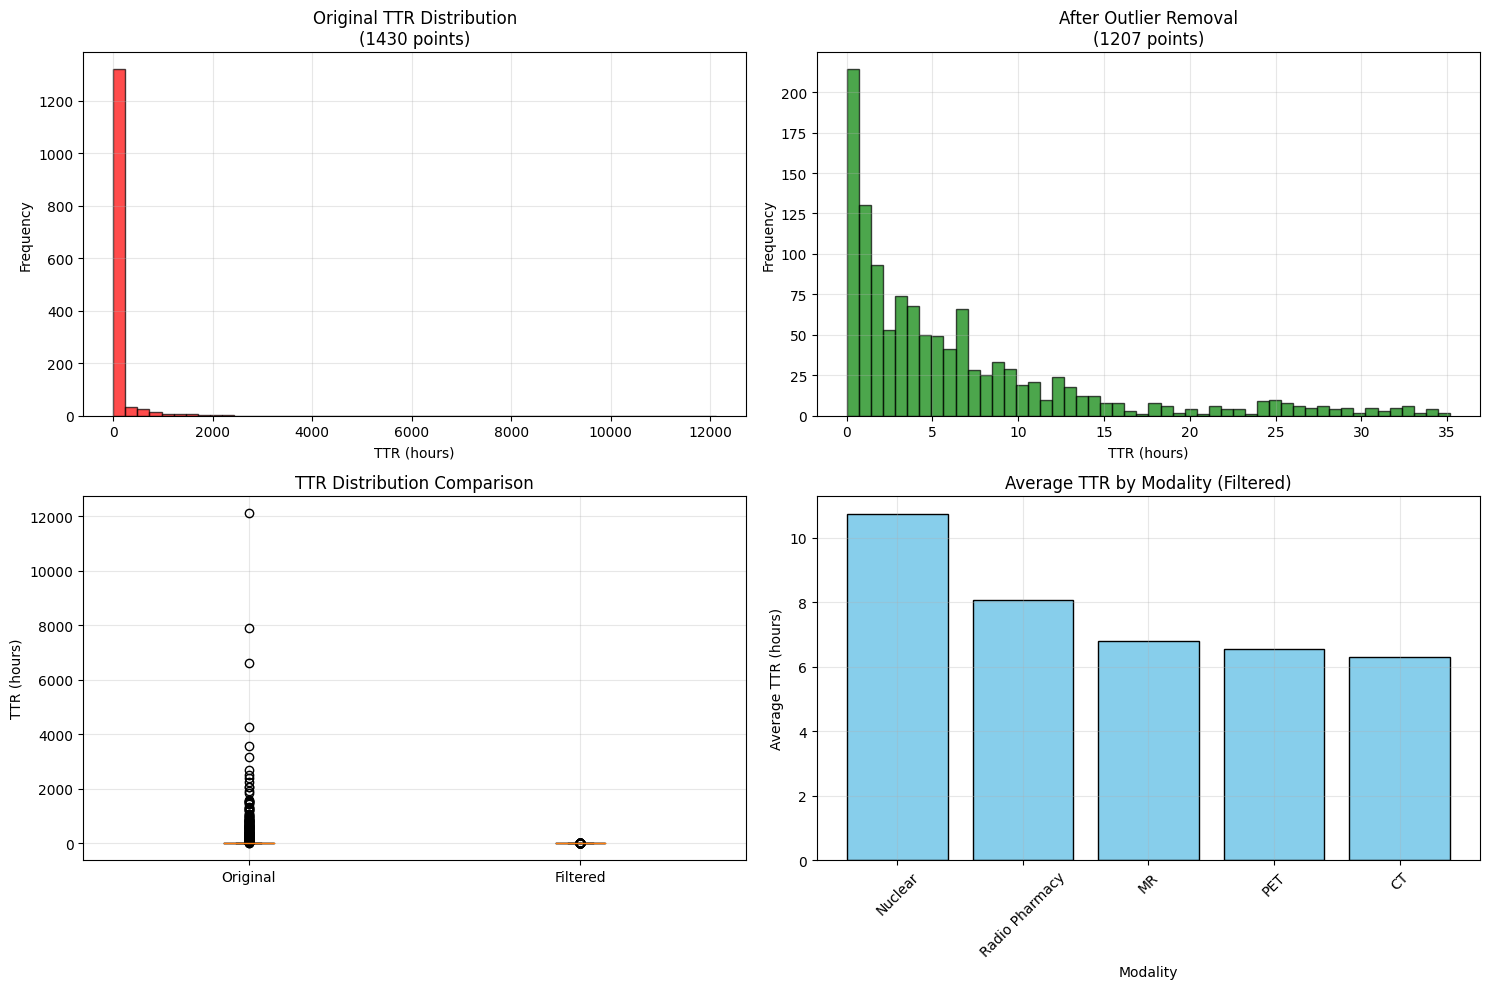


Final clean dataset: 1207 records
TTR statistics after cleaning:
  Min: 0.02 hours
  Max: 35.16 hours
  Mean: 6.59 hours
  Std: 7.60 hours

TRAINING MODELS ON CLEAN DATA (NO OUTLIERS)

Training set: 965 samples
Testing set: 242 samples

Training XGBoost...
XGBoost Results:
  MAE: 5.21 hours, RMSE: 7.52 hours, R2: -0.2824
  Accuracy within 1 hour: 16.1%
  Accuracy within 2 hours: 31.4%
  Accuracy within 4 hours: 54.5%
  Accuracy within 10%: 6.2%
  Accuracy within 25%: 15.7%

Training Random Forest...
Random Forest Results:
  MAE: 5.03 hours, RMSE: 6.98 hours, R2: -0.1036
  Accuracy within 1 hour: 14.0%
  Accuracy within 2 hours: 25.2%
  Accuracy within 4 hours: 52.1%
  Accuracy within 10%: 4.5%
  Accuracy within 25%: 15.3%

Training Gradient Boosting...
Gradient Boosting Results:
  MAE: 5.26 hours, RMSE: 7.60 hours, R2: -0.3104
  Accuracy within 1 hour: 17.4%
  Accuracy within 2 hours: 31.0%
  Accuracy within 4 hours: 54.1%
  Accuracy within 10%: 6.6%
  Accuracy within 25%: 13.6%

🎯 BE

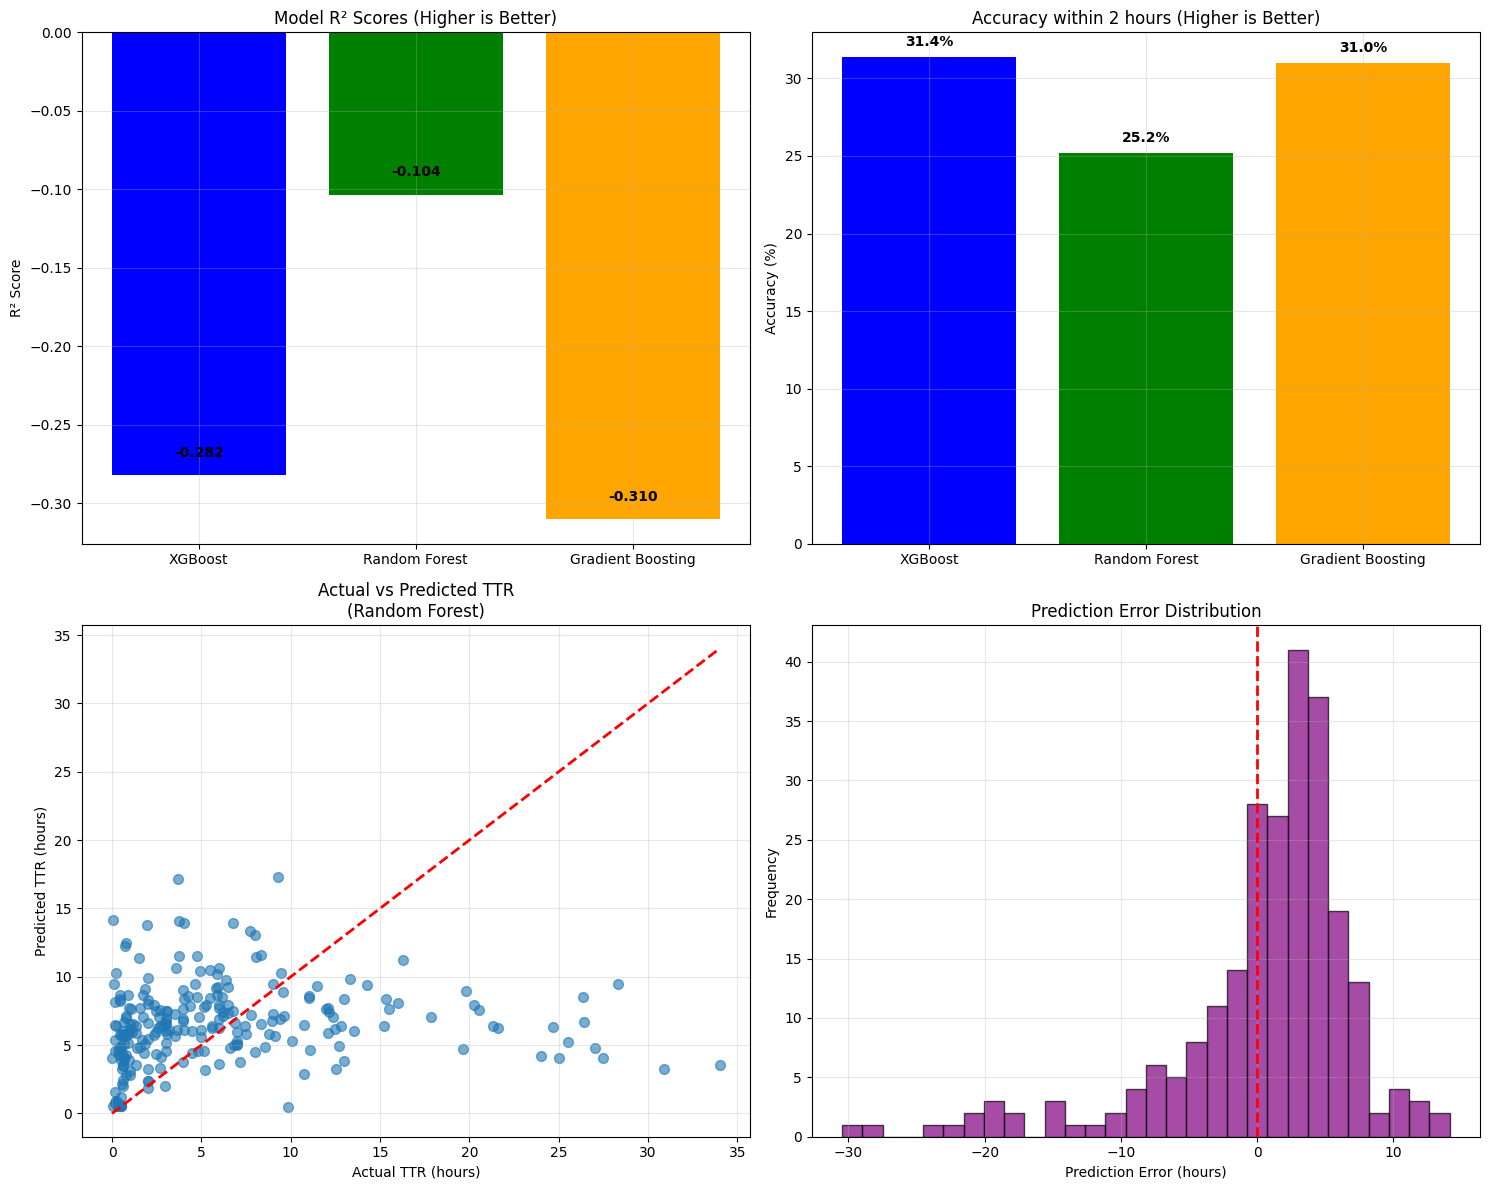


CLEAN DATA MODELING COMPLETE
✅ Outliers removed using IQR method
✅ Working with 1207 clean data points
✅ Best model: Random Forest


In [12]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest, f_regression
import xgboost as xgb
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scipy import stats

# Text preprocessing class
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        # Add domain-specific stop words
        self.stop_words.update(['system', 'error', 'issue', 'problem', 'found', 'need', 'required', 'check'])
    
    def preprocess_text(self, text):
        if pd.isna(text):
            return ""
        
        # Convert to lowercase
        text = str(text).lower()
        
        # Remove special characters but keep some meaningful patterns
        text = re.sub(r'[^a-zA-Z0-9\s\-]', '', text)
        
        # Tokenize and remove stopwords
        tokens = text.split()
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens if token not in self.stop_words and len(token) > 2]
        
        return ' '.join(tokens)

# Function to detect and remove outliers using multiple methods
def remove_ttr_outliers(ttr_data, target_column='SR_TTR', method='iqr', visualize=True):
    """
    Remove outliers from TTR data using specified method
    """
    original_count = len(ttr_data)
    print(f"Original data points: {original_count}")
    
    if method == 'iqr':
        # IQR method - robust for skewed data
        Q1 = ttr_data[target_column].quantile(0.25)
        Q3 = ttr_data[target_column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        filtered_data = ttr_data[(ttr_data[target_column] >= lower_bound) & 
                                (ttr_data[target_column] <= upper_bound)]
        
        print(f"IQR Method: Q1={Q1:.2f}, Q3={Q3:.2f}, IQR={IQR:.2f}")
        print(f"Bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
        
    elif method == 'zscore':
        # Z-score method (remove beyond 3 standard deviations)
        z_scores = stats.zscore(ttr_data[target_column])
        filtered_data = ttr_data[(np.abs(z_scores) < 3)]
        print("Z-score Method: Removed points beyond 3 standard deviations")
        
    elif method == 'quantile':
        # Remove top and bottom 5%
        lower_quantile = ttr_data[target_column].quantile(0.05)
        upper_quantile = ttr_data[target_column].quantile(0.95)
        filtered_data = ttr_data[(ttr_data[target_column] >= lower_quantile) & 
                                (ttr_data[target_column] <= upper_quantile)]
        print(f"Quantile Method: Keeping 5th to 95th percentile [{lower_quantile:.2f}, {upper_quantile:.2f}]")
    
    elif method == 'modality_specific':
        # Remove outliers within each modality group
        filtered_data = pd.DataFrame()
        for modality in ttr_data['OPH_Modality'].unique():
            modality_data = ttr_data[ttr_data['OPH_Modality'] == modality]
            Q1 = modality_data[target_column].quantile(0.25)
            Q3 = modality_data[target_column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            modality_clean = modality_data[
                (modality_data[target_column] >= lower_bound) & 
                (modality_data[target_column] <= upper_bound)
            ]
            filtered_data = pd.concat([filtered_data, modality_clean])
        
        print("Modality-specific IQR Method: Applied IQR separately for each modality")
    
    removed_count = original_count - len(filtered_data)
    print(f"Removed {removed_count} outliers ({removed_count/original_count*100:.1f}% of data)")
    print(f"Remaining data points: {len(filtered_data)}")
    print(f"New TTR range: {filtered_data[target_column].min():.2f} to {filtered_data[target_column].max():.2f} hours")
    print(f"New average TTR: {filtered_data[target_column].mean():.2f} hours")
    
    # Visualize before and after
    if visualize:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Before outlier removal
        axes[0, 0].hist(ttr_data[target_column], bins=50, alpha=0.7, color='red', edgecolor='black')
        axes[0, 0].set_title(f'Original TTR Distribution\n({original_count} points)')
        axes[0, 0].set_xlabel('TTR (hours)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].grid(True, alpha=0.3)
        
        # After outlier removal
        axes[0, 1].hist(filtered_data[target_column], bins=50, alpha=0.7, color='green', edgecolor='black')
        axes[0, 1].set_title(f'After Outlier Removal\n({len(filtered_data)} points)')
        axes[0, 1].set_xlabel('TTR (hours)')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Boxplot comparison
        boxplot_data = [ttr_data[target_column], filtered_data[target_column]]
        axes[1, 0].boxplot(boxplot_data, labels=['Original', 'Filtered'])
        axes[1, 0].set_title('TTR Distribution Comparison')
        axes[1, 0].set_ylabel('TTR (hours)')
        axes[1, 0].grid(True, alpha=0.3)
        
        # TTR by modality (after filtering)
        modality_means = filtered_data.groupby('OPH_Modality')[target_column].mean().sort_values(ascending=False)
        axes[1, 1].bar(modality_means.index, modality_means.values, color='skyblue', edgecolor='black')
        axes[1, 1].set_title('Average TTR by Modality (Filtered)')
        axes[1, 1].set_xlabel('Modality')
        axes[1, 1].set_ylabel('Average TTR (hours)')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return filtered_data

# Prepare clean data without outliers
def prepare_clean_ttr_data(df, outlier_method='iqr'):
    """
    Prepare TTR data with outliers removed
    """
    # Filter relevant columns and clean data
    ttr_data = df[['SR_TTR', 'OPH_Modality', 'product_identifier', 'SR_Type_STD', 
                   'activity_problem_found', 'City', 'OPH_Product_Line']].copy()
    
    # Remove rows with missing TTR values
    ttr_data = ttr_data[ttr_data['SR_TTR'].notna() & (ttr_data['SR_TTR'] > 0)]
    
    print("=" * 60)
    print("DATA CLEANING AND OUTLIER REMOVAL")
    print("=" * 60)
    
    # Remove outliers
    clean_ttr_data = remove_ttr_outliers(ttr_data, method=outlier_method, visualize=True)
    
    # Fill missing categorical data
    categorical_columns = ['OPH_Modality', 'product_identifier', 'SR_Type_STD', 'City', 'OPH_Product_Line']
    for col in categorical_columns:
        clean_ttr_data[col] = clean_ttr_data[col].fillna('Unknown')
    
    clean_ttr_data['activity_problem_found'] = clean_ttr_data['activity_problem_found'].fillna('unknown problem')
    
    # Create additional features from problem description
    clean_ttr_data['problem_length'] = clean_ttr_data['activity_problem_found'].str.len()
    clean_ttr_data['word_count'] = clean_ttr_data['activity_problem_found'].str.split().str.len()
    
    # Create binary features for common problem types
    problem_keywords = {
        'reboot': 'reboot|restart|boot',
        'pressure': 'pressure|psi|bar',
        'temperature': 'temperature|temp|heat',
        'error_code': 'error|fault|failure',
        'monitor': 'monitor|check|flow',
        'hardware': 'hardware|component|part',
        'software': 'software|system|application',
        'network': 'network|connection|communication',
        'remote_fix': 'remote|insite|online'
    }
    
    for feature_name, pattern in problem_keywords.items():
        clean_ttr_data[f'has_{feature_name}'] = clean_ttr_data['activity_problem_found'].str.contains(
            pattern, case=False, na=False
        ).astype(int)
    
    print(f"\nFinal clean dataset: {len(clean_ttr_data)} records")
    print(f"TTR statistics after cleaning:")
    print(f"  Min: {clean_ttr_data['SR_TTR'].min():.2f} hours")
    print(f"  Max: {clean_ttr_data['SR_TTR'].max():.2f} hours")
    print(f"  Mean: {clean_ttr_data['SR_TTR'].mean():.2f} hours")
    print(f"  Std: {clean_ttr_data['SR_TTR'].std():.2f} hours")
    
    return clean_ttr_data

# Let user choose outlier removal method
print("Available outlier removal methods:")
print("1. iqr - Interquartile Range (recommended for skewed data)")
print("2. zscore - Z-score (3 standard deviations)")
print("3. quantile - 5th to 95th percentile")
print("4. modality_specific - IQR per modality group")

# Use IQR method as default (you can change this)
outlier_method = 'iqr'
clean_ttr_data = prepare_clean_ttr_data(df, outlier_method=outlier_method)

# Enhanced model training on clean data
def train_clean_ttr_model(clean_ttr_data):
    """
    Train TTR prediction model on cleaned data without outliers
    """
    # Initialize text preprocessor
    text_preprocessor = TextPreprocessor()
    
    # Preprocess text data
    clean_ttr_data['processed_problem_text'] = clean_ttr_data['activity_problem_found'].apply(
        text_preprocessor.preprocess_text
    )
    
    # Prepare features and target
    feature_columns = [
        'OPH_Modality', 'product_identifier', 'SR_Type_STD', 'City', 'OPH_Product_Line',
        'processed_problem_text', 'problem_length', 'word_count'
    ] + [f'has_{feature}' for feature in ['reboot', 'pressure', 'temperature', 'error_code', 
                                        'monitor', 'hardware', 'software', 'network', 'remote_fix']]
    
    X = clean_ttr_data[feature_columns]
    y = clean_ttr_data['SR_TTR']  # Using original scale since outliers are removed
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, 
        stratify=clean_ttr_data['OPH_Modality']  # Maintain modality distribution
    )
    
    print(f"\nTraining set: {len(X_train)} samples")
    print(f"Testing set: {len(X_test)} samples")
    
    # Create enhanced column transformer
    categorical_features = ['OPH_Modality', 'product_identifier', 'SR_Type_STD', 'City', 'OPH_Product_Line']
    numerical_features = ['problem_length', 'word_count'] + [f'has_{feature}' for feature in 
                                                           ['reboot', 'pressure', 'temperature', 'error_code', 
                                                            'monitor', 'hardware', 'software', 'network', 'remote_fix']]
    text_features = 'processed_problem_text'
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', RobustScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', max_categories=25, sparse_output=False), categorical_features),
            ('text', Pipeline([
                ('tfidf', TfidfVectorizer(max_features=500, ngram_range=(1, 2), min_df=2)),
                ('svd', TruncatedSVD(n_components=30))
            ]), text_features)
        ])
    
    # Models optimized for clean data
    models = {
        'XGBoost': xgb.XGBRegressor(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        ),
        'Random Forest': RandomForestRegressor(
            n_estimators=150,
            max_depth=12,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=150,
            max_depth=5,
            learning_rate=0.1,
            subsample=0.8,
            random_state=42
        )
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Create pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        
        # Train model
        pipeline.fit(X_train, y_train)
        
        # Predictions
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        # Calculate percentage within different error ranges
        absolute_errors = np.abs(y_pred - y_test)
        relative_errors = absolute_errors / y_test
        
        within_1_hour = (absolute_errors <= 1).mean() * 100
        within_2_hours = (absolute_errors <= 2).mean() * 100
        within_4_hours = (absolute_errors <= 4).mean() * 100
        within_10_percent = (relative_errors <= 0.1).mean() * 100
        within_25_percent = (relative_errors <= 0.25).mean() * 100
        
        results[name] = {
            'model': pipeline,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'within_1_hour': within_1_hour,
            'within_2_hours': within_2_hours,
            'within_4_hours': within_4_hours,
            'within_10_percent': within_10_percent,
            'within_25_percent': within_25_percent,
            'predictions': y_pred,
            'true_values': y_test
        }
        
        print(f"{name} Results:")
        print(f"  MAE: {mae:.2f} hours, RMSE: {rmse:.2f} hours, R2: {r2:.4f}")
        print(f"  Accuracy within 1 hour: {within_1_hour:.1f}%")
        print(f"  Accuracy within 2 hours: {within_2_hours:.1f}%")
        print(f"  Accuracy within 4 hours: {within_4_hours:.1f}%")
        print(f"  Accuracy within 10%: {within_10_percent:.1f}%")
        print(f"  Accuracy within 25%: {within_25_percent:.1f}%")
    
    return results, X_train, X_test, y_train, y_test, clean_ttr_data

# Train models on clean data
print("\n" + "="*60)
print("TRAINING MODELS ON CLEAN DATA (NO OUTLIERS)")
print("="*60)

clean_results, X_train, X_test, y_train, y_test, clean_ttr_data = train_clean_ttr_model(clean_ttr_data)

# Identify best model
best_model_name = max(clean_results.keys(), key=lambda x: clean_results[x]['r2'])
best_model = clean_results[best_model_name]['model']
best_result = clean_results[best_model_name]

print(f"\n🎯 BEST MODEL: {best_model_name}")
print(f"📊 R² Score: {best_result['r2']:.4f}")
print(f"🎯 Accuracy within 2 hours: {best_result['within_2_hours']:.1f}%")
print(f"📈 Accuracy within 25%: {best_result['within_25_percent']:.1f}%")
print(f"⚡ Mean Absolute Error: {best_result['mae']:.2f} hours")

# Prediction function for clean data
def predict_ttr_clean(model, modality, product_id, sr_type, problem_description, city="Unknown", product_line="Unknown"):
    """
    Predict TTR using cleaned model
    """
    # Create input dataframe with all features
    input_data = pd.DataFrame({
        'OPH_Modality': [modality],
        'product_identifier': [product_id],
        'SR_Type_STD': [sr_type],
        'City': [city],
        'OPH_Product_Line': [product_line],
        'activity_problem_found': [problem_description],
        'processed_problem_text': [problem_description]
    })
    
    # Calculate derived features
    input_data['problem_length'] = input_data['activity_problem_found'].str.len()
    input_data['word_count'] = input_data['activity_problem_found'].str.split().str.len()
    
    # Add binary features
    problem_keywords = {
        'reboot': 'reboot|restart|boot',
        'pressure': 'pressure|psi|bar',
        'temperature': 'temperature|temp|heat',
        'error_code': 'error|fault|failure',
        'monitor': 'monitor|check|flow',
        'hardware': 'hardware|component|part',
        'software': 'software|system|application',
        'network': 'network|connection|communication',
        'remote_fix': 'remote|insite|online'
    }
    
    for feature_name, pattern in problem_keywords.items():
        input_data[f'has_{feature_name}'] = input_data['activity_problem_found'].str.contains(
            pattern, case=False, na=False
        ).astype(int)
    
    # Preprocess text
    text_preprocessor = TextPreprocessor()
    input_data['processed_problem_text'] = input_data['processed_problem_text'].apply(
        text_preprocessor.preprocess_text
    )
    
    # Predict TTR
    predicted_ttr = model.predict(input_data)[0]
    
    return max(0.1, predicted_ttr)

# Test predictions on clean data
print("\n" + "="*60)
print("PREDICTION EXAMPLES ON CLEAN DATA")
print("="*60)

clean_examples = [
    {
        'modality': 'CT',
        'product_id': 'CSPL22',
        'sr_type': 'Corrective Repair',
        'problem': 'System no reboot for more than 8 days',
        'city': 'Dhaka',
        'product_line': 'CT_GE'
    },
    {
        'modality': 'MR',
        'product_id': 'MSF154',
        'sr_type': 'Corrective Repair', 
        'problem': 'Magnet Monitor Data Flow Checks - No data flow',
        'city': 'BARISAL',
        'product_line': 'MR_GE'
    },
    {
        'modality': 'Radio Pharmacy',
        'product_id': 'PTM003',
        'sr_type': 'Corrective Repair',
        'problem': 'Target pressure fault',
        'city': 'DHAKA',
        'product_line': 'Radio Pharmacy_GE'
    }
]

for i, example in enumerate(clean_examples, 1):
    predicted_ttr = predict_ttr_clean(
        best_model,
        example['modality'],
        example['product_id'], 
        example['sr_type'],
        example['problem'],
        example['city'],
        example['product_line']
    )
    
    print(f"\nExample {i}:")
    print(f"📍 {example['modality']} | {example['product_id']} | {example['city']}")
    print(f"🔧 {example['problem'][:80]}...")
    print(f"⏰ Predicted TTR: {predicted_ttr:.2f} hours")

# Visualize model performance on clean data
def visualize_clean_results(clean_results, clean_ttr_data):
    """
    Visualize results from clean data modeling
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Model performance comparison
    model_names = list(clean_results.keys())
    r2_scores = [clean_results[name]['r2'] for name in model_names]
    accuracy_2hr = [clean_results[name]['within_2_hours'] for name in model_names]
    
    # R² scores
    bars1 = axes[0, 0].bar(model_names, r2_scores, color=['blue', 'green', 'orange'])
    axes[0, 0].set_ylabel('R² Score')
    axes[0, 0].set_title('Model R² Scores (Higher is Better)')
    axes[0, 0].grid(True, alpha=0.3)
    for bar, score in zip(bars1, r2_scores):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                       f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Accuracy within 2 hours
    bars2 = axes[0, 1].bar(model_names, accuracy_2hr, color=['blue', 'green', 'orange'])
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].set_title('Accuracy within 2 hours (Higher is Better)')
    axes[0, 1].grid(True, alpha=0.3)
    for bar, acc in zip(bars2, accuracy_2hr):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                       f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Actual vs Predicted for best model
    best_model_name = max(clean_results.keys(), key=lambda x: clean_results[x]['r2'])
    y_pred = clean_results[best_model_name]['predictions']
    y_true = clean_results[best_model_name]['true_values']
    
    axes[1, 0].scatter(y_true, y_pred, alpha=0.6, s=50)
    max_val = max(y_true.max(), y_pred.max())
    axes[1, 0].plot([0, max_val], [0, max_val], 'r--', linewidth=2)
    axes[1, 0].set_xlabel('Actual TTR (hours)')
    axes[1, 0].set_ylabel('Predicted TTR (hours)')
    axes[1, 0].set_title(f'Actual vs Predicted TTR\n({best_model_name})')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Error distribution
    errors = y_pred - y_true
    axes[1, 1].hist(errors, bins=30, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[1, 1].set_xlabel('Prediction Error (hours)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Prediction Error Distribution')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Show results visualization
visualize_clean_results(clean_results, clean_ttr_data)

print("\n" + "="*60)
print("CLEAN DATA MODELING COMPLETE")
print("="*60)
print("✅ Outliers removed using IQR method")
print(f"✅ Working with {len(clean_ttr_data)} clean data points")
print(f"✅ Best model: {best_model_name}")